In [1]:
# the class to hande histograms and some helper functions
import copy
import math
import os

def safediv(a,b):
    if float(b) != 0.:
        return a/b
    else:
        return float('nan')

def get_histo_from_file(fname, hname, htype, nrebin=1, fixrate=False, totrate=0.):
    content = open(fname).read()
    found = False
    xmin = []
    xmax = []
    y = []
    yerr = []
    
    for l in content.split('\n'):

        if l.startswith("<histogram>") and l.split('"')[1].strip().startswith(hname) and \
        ('TYPE@%s|' % htype in l or 'TYPE@%s"' % htype in l or '|T@%s ' % htype in l):
            found = True
            continue
        if found and l.startswith("<\\histogram>"):
            break
        if found:
            values = [float(v) for v in l.split()]
            xmin.append(values[0])
            xmax.append(values[1])
            y.append(values[2])
            yerr.append(values[3])
    if not found:
        print('Not found, ', fname, hname, htype)
        raise HistoNotFound('get_histo_from_file, not found', fname, hname, htype)
    return Histogram(xmin, xmax, y, yerr, fixrate, totrate).rebin(nrebin)


def get_histo_from_datfile(fname, nevents=1., nrebin=1):
    content = open(fname).read()
    xmin = []
    xmax = []
    y = []
    yerr = []
    
    for l in content.split('\n'):
        if not(l): continue
        if l.startswith('#') or l.strip().startswith('No'): continue
        values = [float(v) for v in l.split()]
        xmin.append(values[0])
        xmax.append(values[1])
        y.append(values[2]/nevents)
        if values[3] != 0:
            yerr.append(values[2]/math.sqrt(values[3])/nevents)
        else:
            yerr.append(0)

    return Histogram(xmin, xmax, y, yerr).rebin(nrebin)
            
class HistoNotFound(Exception):
    pass

class Histogram(dict):
    def __init__(self, xmin, xmax, y, yerr, fixrate=False, rate=0.):
        if not (len(xmin)==len(xmax)==len(y)==len(yerr)):
            raise Exception('Init, Invalid size')
                
        self['xmin'] = xmin
        self['xmax'] = xmax
        self['x'] = [(x1+x2)/2 for x1,x2 in zip(xmin,xmax)]
        self['xlo'] = xmin
        self['xhi'] = xmax
        self['y'] = y
        self['yerr'] = yerr
        self['nbins'] = len(xmin)
        
        if fixrate:
            # this is for mtt, with issues related to overflow in the last bin
            # change the rate of the last bin so that the total rate of
            # the histogram is equal to rate
            self['y'][-1] += rate - self.totrate
                
    
    def __add__(self, other):
        if type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('add, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('add, Invalid x')
            return Histogram(self['xmin'], self['xmax'],
                        [y1+y2 for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt(y1**2+y2**2) for y1,y2 in zip(self['yerr'], other['yerr'])])
        elif type(other) in [int, float]:
            return Histogram(self['xmin'], self['xmax'],
                        [y1+other for y1 in self['y']],
                        self['yerr'])
        else:
            raise(Exception, 'invalid type %s' % type(other))
            
    
    def __sub__(self, other):
        return self + (other * (-1))
    
    
    
    def __mul__(self, other):
        if type(other) == float or type(other) == int:
            return Histogram(self['xmin'], self['xmax'],
                    [y1*other for y1 in self['y']],
                        [y1*other for y1 in self['yerr']])
        elif type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('mul, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('mul, Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
            return Histogram(self['xmin'], self['xmax'],
                        [y1*y2 for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt((y1*e2)**2 + (e2*y1)**2) for y1,y2,e1,e2 in zip(self['y'], other['y'], self['yerr'], other['yerr'])])
            
        else:
            raise Exception('mul, not implemented')
            
            
    def __truediv__(self, other):
        if type(other) == float or type(other) == int:
            return Histogram(self['xmin'], self['xmax'],
                    [y1/other for y1 in self['y']],
                        [y1/other for y1 in self['yerr']])
        elif type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('div, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('div, Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
            return Histogram(self['xmin'], self['xmax'],
                        [safediv(y1,y2) for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt(safediv(e1,y2)**2+(safediv(y1,y2**2)*e2)**2) for y1,y2,e1,e2 in zip(self['y'], other['y'], self['yerr'], other['yerr'])])
            
        else:
            raise Exception('div, not implemented')
            
    
    def rebin(self, nbins):
        if (self['nbins']//nbins)*nbins != self['nbins']:
            print('cannot rebin')
            return self
        if nbins == 1:
            return self
        xmin = []
        xmax = []
        y = []
        yerr = []
        for i in range(self['nbins']//nbins):
            i0 = i * nbins
            i1 = (i+1) * nbins  - 1
            xmin.append(self['xmin'][i0])
            xmax.append(self['xmax'][i1])
            y.append(sum(self['y'][i0:i1+1]))
            yerr.append(math.sqrt(sum([err**2 for err in self['yerr'][i0:i1+1]])))
        
        return Histogram(xmin,xmax,y,yerr)
    
    def replacefirstbins(self, other, xx):
        ### replace the first bins of self (with x < xx) with those of others
        if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
            raise Exception('Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
        
        #find the first x > xx
        for i, x in enumerate(self['x']):
            if x > xx:
                break
        self['y'] = other['y'][:i] + self['y'][i:]
        self['yerr'] = other['yerr'][:i] + self['yerr'][i:]
        
    
        
    
    def maxv_n(self, i):
        """return the next^i to maximum"""
        values = sorted(self['y'], reverse=True)
        return values[i]
    
    @property
    def maxv(self):
        return max(self['y'])
    
    
    @property
    def totrate(self):
        return sum(self['y'])
        
    @property
    def minv(self):
        return min([v for v in self['y'] if v not in [0, -100]])


In [2]:
# matplotlib setup and some definitions
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
lw = 1.2
allcolors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
allcolors[1] = 'black'
allcolors[0] = 'blue'
allcolors[3] = 'red'
import matplotlib.font_manager as font_manager
import matplotlib.backends.backend_pdf as backend_pdf
from matplotlib.ticker import MultipleLocator,AutoMinorLocator

import matplotlib as mpl
#mpl.rcParams.update({"mathtext.fontset": "dejavuserif"})
mpl.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 14})
mpl.rcParams.update({'lines.markersize': 8})
#mpl.rcParams.update({'lines.linewidth': 0.5})
markers_glob = ['o', 'v', 's', '<', '>', 's', 'p', '*', 'h', 'p', 'x', 'X', 'd']
font_legend = font_manager.FontProperties(size=10)

def update_legend(ax, ncol):
    # this is to have the line in the legend, and not the square
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    for i, h in enumerate(handles):
        ls = h.get_linestyle()
        lc = h.get_edgecolor()
        #mk = markers[i]
        if ls == 'dashed':
            facecolor = 'none'
        else:
            facecolor = lc
        #new_handles.append(mlines.Line2D([], [], c=lc, linestyle=ls, marker = mk, markerfacecolor = facecolor))
        new_handles.append(mlines.Line2D([], [], c=lc, linestyle=ls, markerfacecolor = facecolor))

    ax.legend(handles=new_handles, labels=labels, prop=font_legend, frameon = False, ncol=ncol,
              loc='upper left', bbox_to_anchor=(1, 1.1))


xlabels = {'tt': {'mtt': 'm(t\\bar t)',
                  'pttt': 'p_T(t\\bar t)',
                  'pttop': 'p_T(t)',
                  'thetatt': '\\theta(t\\bar t)',
                  'top rap': 'y(t)',
                  'tt rap': 'y(t\\bar t)'},
           'ww': {'mtt': 'm(W^+W^-)',
                  'pttt': 'p_T(W^+W^-)',
                  'pttop': 'p_T(W^+)',
                  'thetatt': '\\theta(W^+W^-)',
                  'top rap': 'y(W^+)',
                  'tt rap': 'y(W^+W^-)'}}
proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}





tt 3 mtt
tt 3 pttop
tt 10 mtt
tt 10 pttop
ww 3 mtt
ww 3 pttop
ww 10 mtt
ww 10 pttop


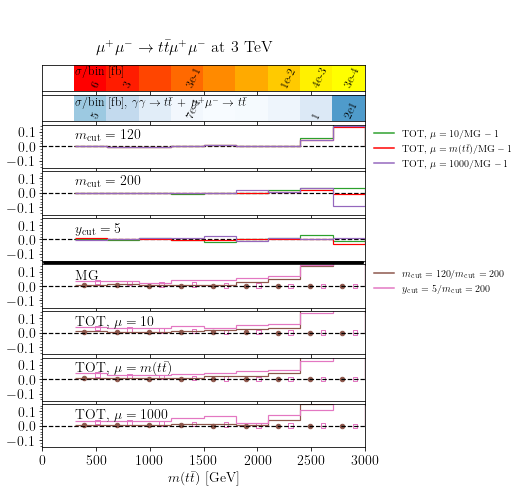

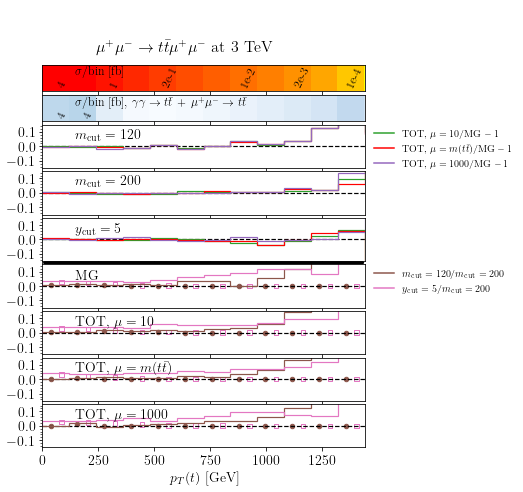

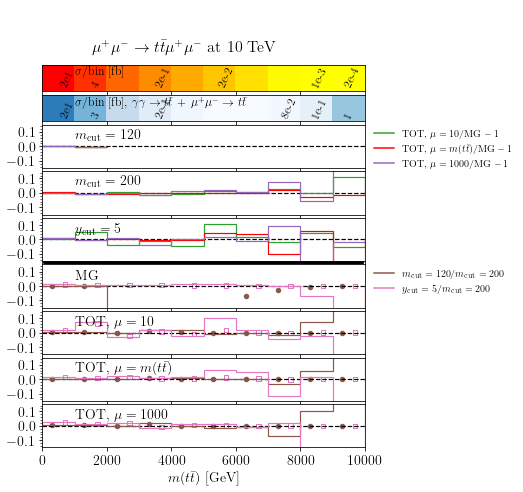

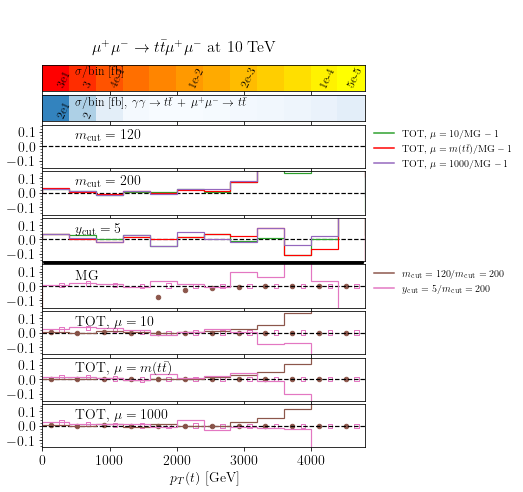

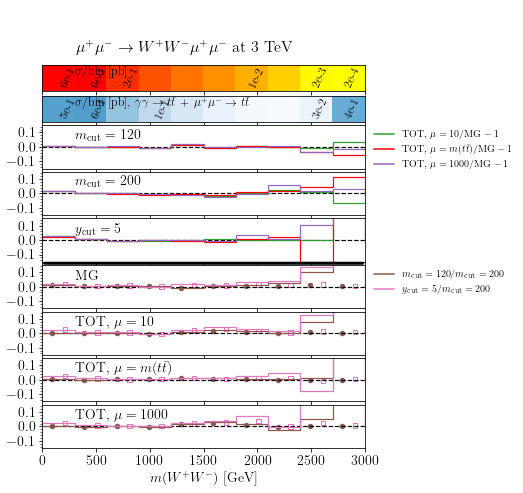

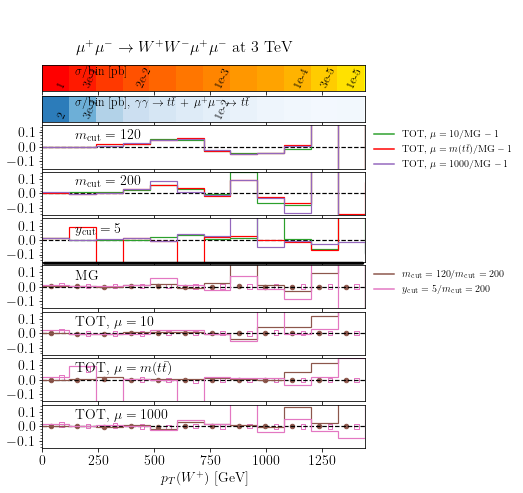

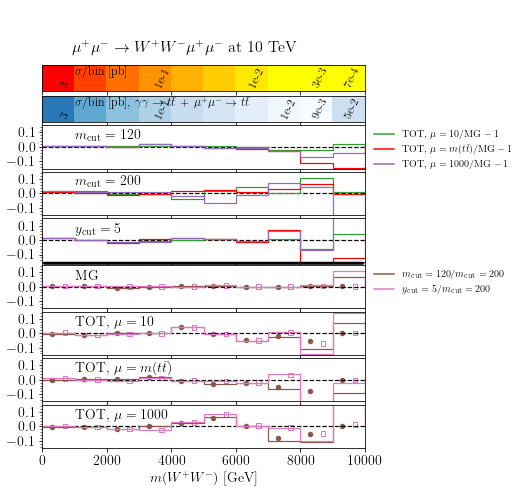

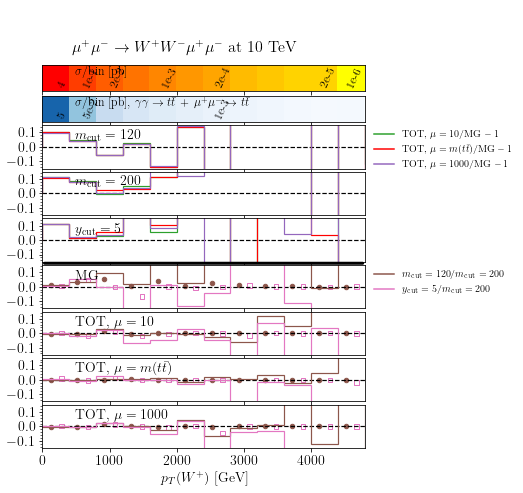

In [10]:
# Main plots for the technical paper
# mtt, compare m[mumu]>200 with ycuts
from matplotlib.colors import LogNorm
nrebin = 5 
import math
import itertools


def get_label_pos(histo, ypos=0.5):
    """find the label positions where the log10 of the xsection per bin increases by one unity
    always move towards the maximum"""
    imax = histo['y'].index(max(histo['y']))
    # from the left to the right
    lastlog = -20
    labels_left = []
    labels_left.append((histo['x'][imax], ypos, histo['y'][imax]))
    # from the left to the max
    for x, y in zip(histo['x'][:imax], histo['y'][:imax]):
        if y == 0: continue
        if lint(math.log10(y)) != lastlog:
            lastlog = lint(math.log10(y))
            #labels_left.append((x, ypos, 10.**lastlog))
            labels_left.append((x, ypos, y))
    labels_right = []
    # from the right to the max
    lastlog=-20
    for x, y in reversed(list(zip(histo['x'][imax+1:], histo['y'][imax+1:]))):
        if y == 0: continue
        if lint(math.log10(y)) != lastlog:
            lastlog = lint(math.log10(y))

            #labels_right.append((x, ypos,10.**lastlog))
            labels_right.append((x, ypos,y))
    return labels_left + list(reversed(labels_right))

def lint(v):
    """returns the largest integer i for which i < v """
    if v > 0:
        return int(v)
    else:
        return int(v) - 1

def put_labels(ax, labels, color='w', fontsize=11, rotation=0):
    for x, y, v in labels:
        #if int(v) != 0:
        #    ss = '%d' % v
        #elif int(v*10) !=0:
        #    ss = '%.1f' % v
        #    ss = ss[1:]
        #elif int(v*100) !=0:
        #    ss = '%.2f' % v
        #    ss = ss[1:]
        #elif int(v*1000) !=0:
        #    ss = '%.3f' % v
        #    ss = ss[1:]
        #elif int(v*10000) !=0:
        #    ss = '%.4f' % v
        #    ss = ss[1:]
        #else:
        #    ss = 'AAAA'
        ss = "%.0e" % v
        ss = ss.replace('e+00', '')
        ss = ss.replace('+0', '')
        ss = ss.replace('-0', '-')
        ax.annotate(ss, xy = (x*0.98,y), color = color, fontsize= fontsize, rotation=rotation)
    
            
        
        
    
for p, en, o in itertools.product(['tt', 'ww'], [3,10], ['mtt', 'pttop']):
#for p, en, o in itertools.product(['ww'], [3], ['mtt']):

#for p, en in itertools.product(['tt',], [3,10]):
    print(p, en, o)
    fname_mg_m200 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_biasmtt4_new.dat' % (o, en))
    if en==10:
        fname_mg_m200_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_biasmtt2_new.dat' % en)
    fname_nnlo1000_m200 = os.path.join(p, 'run_%dtev_comparemassive_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m200 = os.path.join(p, 'run_%dtev_comparemassive_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m200 = os.path.join(p, 'run_%dtev_comparemassive_mumtt' % en, 'MADatNLO.HwU')

    #fname_mg_y25 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_ymax2.5_biasmtt4_new.dat' % (o, en)) 
    #if en ==10:
    #    fname_mg_y25_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax2.5_biasmtt2_new.dat' % en)   
    #fname_nnlo1000_y25 = os.path.join(p, 'run_%d000tev_comparemassive_ymax2.5_mufix1000' % en, 'MADatNLO.HwU')
    #fname_nnlo10_y25 = os.path.join(p, 'run_%d000tev_comparemassive_ymax2.5_mufix10' % en, 'MADatNLO.HwU')
    #fname_nnlomtt_y25 = os.path.join(p, 'run_%dtev_comparemassive_ycut2.5_mumtt' % en, 'MADatNLO.HwU')
    
    fname_mg_y5 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_ymax5_biasmtt4_new.dat' % (o, en))
    if en ==10:
        fname_mg_y5_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax5_biasmtt2_new.dat' % en) 
    fname_nnlo1000_y5 = os.path.join(p, 'run_%dtev_comparemassive_ymax5.0_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_y5 = os.path.join(p, 'run_%dtev_comparemassive_ymax5.0_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_y5 = os.path.join(p, 'run_%dtev_comparemassive_ycut5.0_mumtt' % en, 'MADatNLO.HwU')

    fname_nnlo1000_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mumtt' % en, 'MADatNLO.HwU')
    
    fname_mg_m120 = os.path.join(p, 'massive_madevent', 'histo_%s_%dtev_mcut120_biasmtt4_new.dat' % (o, en))
    if en ==10:
        fname_mg_m120_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_mcut120_biasmtt2_new.dat' % en)     
    #fname_nnlo1000_m120_y25 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut2.5_mufix1000' % en, 'MADatNLO.HwU')
    #fname_nnlo10_m120_y25 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut2.5_mufix10' % en, 'MADatNLO.HwU')
    #fname_nnlomtt_m120_y25 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut2.5_mumtt' % en, 'MADatNLO.HwU')
    
    #fname_nnlo1000_m120_y5 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut5.0_mufix1000' % en, 'MADatNLO.HwU')
    #fname_nnlo10_m120_y5 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut5.0_mufix10' % en, 'MADatNLO.HwU')
    #fname_nnlomtt_m120_y5 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut5.0_mumtt' % en, 'MADatNLO.HwU')
    
    fname_lotot = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_03permil' % en, 'MADatNLO.HwU')
    
    if o == 'mtt':
        obsrange = (0,en*1000)
        nrebin = 5
    if o == 'pttop':
        obsrange = (0,en*1000/2 * 12/12.5)
        nrebin = 2
        
    #histograms
    h_mg_m120 = get_histo_from_datfile(fname_mg_m120, 1e6, nrebin)
    h_mg_m200 = get_histo_from_datfile(fname_mg_m200, 1e6, nrebin)
    #h_mg_y25 = get_histo_from_datfile(fname_mg_y25, 1e6, nrebin)
    h_mg_y5 = get_histo_from_datfile(fname_mg_y5, 1e6, nrebin)
    
    if en == 10 and o == 'mtt':
        h_mg_m120_other = get_histo_from_datfile(fname_mg_m120_other, 1e6, nrebin)
        h_mg_m200_other = get_histo_from_datfile(fname_mg_m200_other, 1e6, nrebin)
        #h_mg_y25_other = get_histo_from_datfile(fname_mg_y25_other, 1e6, nrebin)
        h_mg_y5_other = get_histo_from_datfile(fname_mg_y5_other, 1e6, nrebin)
        h_mg_m120.replacefirstbins(h_mg_m120_other, 2001.)
        h_mg_m200.replacefirstbins(h_mg_m200_other, 2001.)
        #h_mg_y25.replacefirstbins(h_mg_y25_other, 2001.)
        h_mg_y5.replacefirstbins(h_mg_y5_other, 2001.)
    
    h_nnlo_1000_m200 = get_histo_from_file(fname_nnlo1000_m200, o, 'TOT', nrebin)
    #h_nnlo_1000_y25 = get_histo_from_file(fname_nnlo1000_y25, o, 'TOT', nrebin)
    h_nnlo_1000_y5 = get_histo_from_file(fname_nnlo1000_y5, o, 'TOT', nrebin)
    
    h_nnlo_mtt_m200 = get_histo_from_file(fname_nnlomtt_m200, o, 'TOT', nrebin)
    #h_nnlo_mtt_y25 = get_histo_from_file(fname_nnlomtt_y25, o, 'TOT', nrebin)
    h_nnlo_mtt_y5 = get_histo_from_file(fname_nnlomtt_y5, o, 'TOT', nrebin)

    h_nnlo_10_m200 = get_histo_from_file(fname_nnlo10_m200, o, 'TOT', nrebin)
    #h_nnlo_10_y25 = get_histo_from_file(fname_nnlo10_y25, o, 'TOT', nrebin)
    h_nnlo_10_y5 = get_histo_from_file(fname_nnlo10_y5, o, 'TOT', nrebin)
    
    h_nnlo_1000_m120 = get_histo_from_file(fname_nnlo1000_m120, o, 'TOT', nrebin)
    #h_nnlo_1000_m120_y25 = get_histo_from_file(fname_nnlo1000_m120_y25, o, 'TOT', nrebin)
    #h_nnlo_1000_m120_y5 = get_histo_from_file(fname_nnlo1000_m120_y5, o, 'TOT', nrebin)

    h_nnlo_10_m120 = get_histo_from_file(fname_nnlo10_m120, o, 'TOT', nrebin)
    #h_nnlo_10_m120_y25 = get_histo_from_file(fname_nnlo10_m120_y25, o, 'TOT', nrebin)
    #h_nnlo_10_m120_y5 = get_histo_from_file(fname_nnlo10_m120_y5, o, 'TOT', nrebin)
    
    h_nnlo_mtt_m120 = get_histo_from_file(fname_nnlomtt_m120, o, 'TOT', nrebin)
    #h_nnlo_mtt_m120_y25 = get_histo_from_file(fname_nnlomtt_m120_y25, o, 'TOT', nrebin)
    #h_nnlo_mtt_m120_y5 = get_histo_from_file(fname_nnlomtt_m120_y5, o, 'TOT', nrebin)
    
    h_lotot = get_histo_from_file(fname_lotot, o, 'LO', nrebin)
    h_loaa = get_histo_from_file(fname_lotot, o, 'LOAA', nrebin)
    h_ratio_loaa = h_loaa/h_lotot

    # now the figure
    fig, axes = plt.subplots(nrows = 9, ncols= 1, sharex = True, 
                                         gridspec_kw={'height_ratios': [1.2,1.2,2,2,2,2,2,2,2]})
    fig.set_size_inches(7*0.75,7)
    fig.suptitle("\n\n" + "    " + proc_string[p] + '$\\mu^+\\mu^-$' + ' at %d TeV' % en, fontsize=16, y=1.00) 
        
    for ax in axes:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlim(obsrange[0],obsrange[1])
        
    # first inset, ratio with the m(200) cut wrt MG
    ax = axes[0]
    #ax.set_ylim(0.85,1.15)
    #h_ratio = h_mg_m200/h_mg_m200
    if p == 'tt':
        unit = 1000. # convert to fb
        sunit = 'fb'
    elif p == 'ww':
        unit = 1. #stay in pb
        sunit = 'pb'
    
    heatmap=ax.pcolor([h_mg_m200['x']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [[y*unit for y in h_mg_m200['y']]]*2,
             norm=LogNorm(vmin=h_mg_m200.minv*unit*10, vmax=h_mg_m200.maxv*unit), cmap='autumn_r', shading='nearest')
    #contour=ax.contour([h_mg_m200['xlo']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [h_mg_m200['y']]*2,
    #                  levels=[10**i for i in range(-20,20,1)], colors='w')
    # put the labels of xsection levels
    put_labels(ax, get_label_pos(h_mg_m200*unit,-0.25), color='black', fontsize=12, rotation=65)
    ax.annotate('$\\sigma/\\textrm{bin}\\,\\, [\\textrm{%s}]$' % sunit, xy = (obsrange[1]/10,0.75), color = 'black', fontsize= 12)

    ax.get_yaxis().set_visible(False)
    
    ax = axes[1]
    heatmap=ax.pcolor([h_lotot['x']]*2, [[0]*h_lotot['nbins'], [1]*h_lotot['nbins']], [[y*unit for y in h_lotot['y']]]*2,
             norm=LogNorm(vmin=h_lotot.minv*unit, vmax=h_lotot.maxv*unit*10), cmap='Blues', shading='nearest')
    #contour=ax.contour([h_mg_m200['xlo']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [h_mg_m200['y']]*2,
    #                  levels=[10**i for i in range(-20,20,1)], colors='w')
    # put the labels of xsection levels
    put_labels(ax, get_label_pos(h_lotot*unit,-0.25), color='black', fontsize=12, rotation=65)
    ax.annotate('$\\sigma/\\textrm{bin}\\,\\, [\\textrm{%s}]$, $\\gamma\\gamma\\to t\\bar t\\, +\\,\\mu^+\\mu^- \\to t\\bar t$' % sunit, xy = (obsrange[1]/10,0.75), color = 'black', fontsize= 12)

    ax.get_yaxis().set_visible(False)

    ax = axes[2]
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, '$m_{\\rm cut} = 120$')

    h_ratio = h_nnlo_10_m120/h_mg_m120 - 1 
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000), 
            label = '${\\textrm{TOT},\\,\\mu=10}/{\\textrm{MG}} -1$')
    h_ratio = h_nnlo_mtt_m120/h_mg_m120 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000), 
            label = '${\\textrm{TOT},\\,\\mu=m(t\\bar t)}/{\\textrm{MG}} -1$')
    h_ratio = h_nnlo_1000_m120/h_mg_m120 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000), 
            label = '${\\textrm{TOT},\\,\\mu=1000}/{\\textrm{MG}} -1$')
    update_legend(ax, ncol=1)

    ax = axes[3]
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, '$m_{\\rm cut} = 200$')

    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    
    h_ratio = h_nnlo_10_m200/h_mg_m200 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000),)
    h_ratio = h_nnlo_mtt_m200/h_mg_m200 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000),)
    h_ratio = h_nnlo_1000_m200/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000),)

   
    # third inset, ratio with the y=5 cut wrt MG
    ax = axes[4]
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, '$y_{\\rm cut}=5$')
    h_ratio = h_mg_y5/h_mg_y5
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_10_y5/h_mg_y5 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000),)
    h_ratio = h_nnlo_mtt_y5/h_mg_y5 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000),)
    h_ratio = h_nnlo_1000_y5/h_mg_y5 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000),)
    

    #ratios y=2.5 , y=5 /m200, madgraph
    ax = axes[5]
    # put a thick line above
    ax.annotate('', xy=(0.0, 1.04), xycoords='axes fraction', xytext=(1., 1.04), arrowprops=dict(arrowstyle="-", color='black', 
                                                                                             linewidth='3'))
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, 'MG')
    h_ratio = h_mg_m200/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_mg_m120/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = '${m_{\\rm cut}=120}/{m_{\\rm cut}=200}$')
    h_ratio = h_mg_y5/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = '${y_{\\rm cut}=5}/{m_{\\rm cut}=200}$')

    h_ratio_aa = h_ratio_loaa * (h_mg_m120/h_mg_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_mg_y5/h_mg_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', facecolor='none', edgecolor = allcolors[6], s = 20)
    
    update_legend(ax, ncol=1)
    
    
    
    #ratios y=2.5 , y=5 /m200, NNLO mu10
    ax = axes[6]
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, 'TOT, $\\mu=10$')
    h_ratio = h_nnlo_10_m200/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_10_m120/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_10_y5/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')
    
    h_ratio_aa = h_ratio_loaa * (h_nnlo_10_m120/h_nnlo_10_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_nnlo_10_y5/h_nnlo_10_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', facecolor='none', edgecolor = allcolors[6], s = 20)
    
    #ratios y=2.5 , y=5 /m200, NNLO mumtt
    ax = axes[7]
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, 'TOT, $\\mu =m(t\\bar t)$')
    h_ratio = h_nnlo_mtt_m200/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_mtt_m120/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_mtt_y5/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')

    h_ratio_aa = h_ratio_loaa * (h_nnlo_mtt_m120/h_nnlo_mtt_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_nnlo_mtt_y5/h_nnlo_mtt_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', facecolor='none', edgecolor = allcolors[6], s = 20)
    
    
    #ratios y=2.5 , y=5 /m200, NNLO mu1000
    ax = axes[8]
    ax.set_ylim(-0.15,0.15)
    ax.text(obsrange[1]/10, 0.05, 'TOT, $\\mu=1000$')
    h_ratio = h_nnlo_1000_m200/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_1000_m120/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_1000_y5/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')

    h_ratio_aa = h_ratio_loaa * (h_nnlo_1000_m120/h_nnlo_1000_m200 - 1)
    binsize = en*1000/h_ratio_aa['nbins']
    ax.scatter([x - binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 'o', color = allcolors[5], s = 20)

    h_ratio_aa = h_ratio_loaa * (h_nnlo_1000_y5/h_nnlo_1000_m200 - 1)
    ax.scatter([x + binsize/5 for x in h_ratio_aa['x']], h_ratio_aa['y'], marker = 's', facecolor='none', edgecolor = allcolors[6], s = 20)
    
    
    ax.set_xlabel('$%s$ [GeV]' % xlabels[p][o])
    plt.savefig('check_massive2_%s_%s_%dtev.pdf'  % (p,o,en), bbox_inches = 'tight')


cannot rebin
cannot rebin
cannot rebin
cannot rebin
TOTAL 1 mtt tt 0.16763655 0.16752202
TOTAL 1 pttt tt 0.167636542691 0.167522025066
TOTAL 1 pttop tt 0.16763654625000002 0.16752202165
cannot rebin
cannot rebin
cannot rebin
cannot rebin
TOTAL 3 mtt tt 0.028263564000000005 0.028440646999999996
TOTAL 3 pttt tt 0.028263563984999997 0.028440646560800004
TOTAL 3 pttop tt 0.028263564570000007 0.028440646800000004
cannot rebin
cannot rebin
cannot rebin
cannot rebin
TOTAL 10 mtt tt 0.027723079999999997 0.030036253000000006
TOTAL 10 pttt tt 0.027723079818900008 0.0300362530941
TOTAL 10 pttop tt 0.027723080012 0.030036253211000005
cannot rebin
cannot rebin
cannot rebin
cannot rebin
TOTAL 1 mtt ww 3.0996149000000006 3.1004130000000005
TOTAL 1 pttt ww 3.099614916385 3.1004130268029995
TOTAL 1 pttop ww 3.099614944 3.100413022
cannot rebin
cannot rebin
cannot rebin
cannot rebin
TOTAL 3 mtt ww 1.9369253999999998 1.9748574999999997
TOTAL 3 pttt ww 1.9369254475899997 1.9748575026800002
TOTAL 3 pttop w

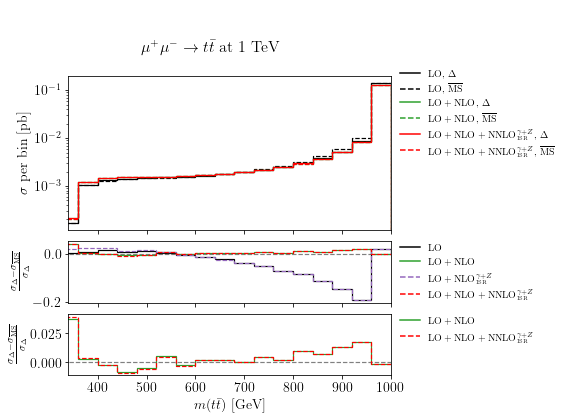

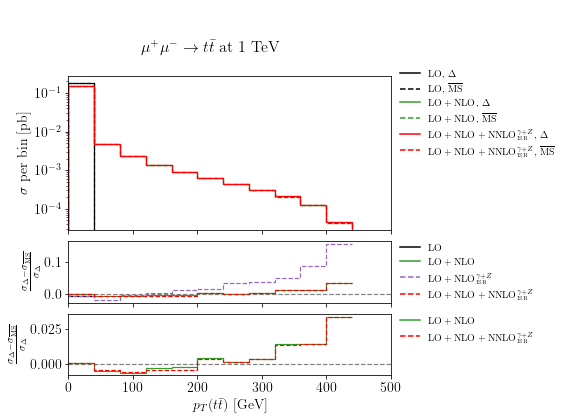

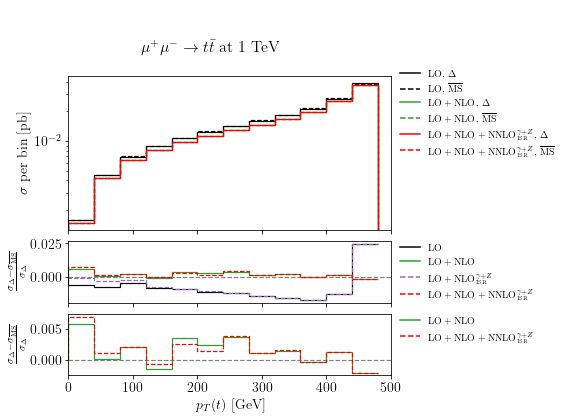

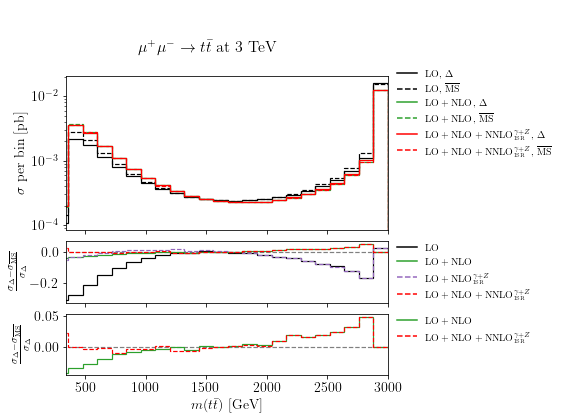

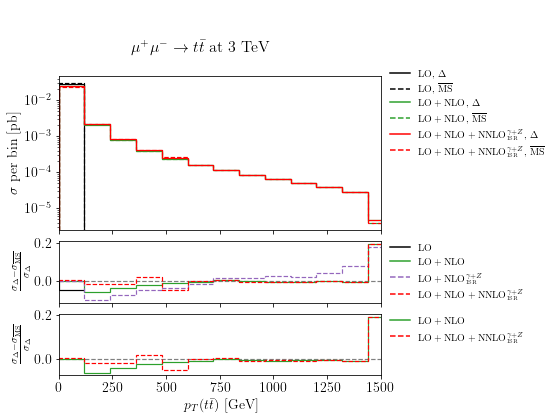

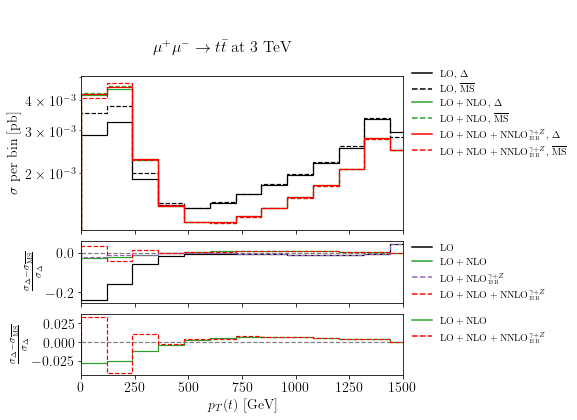

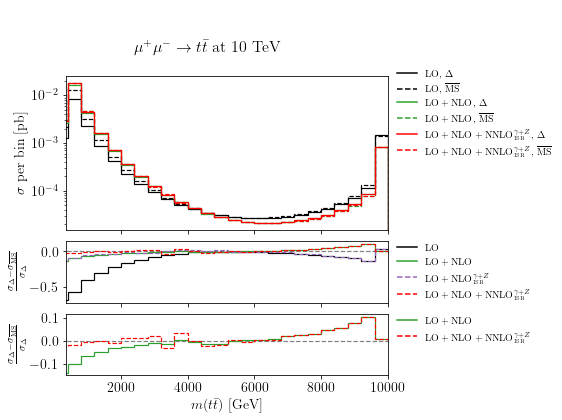

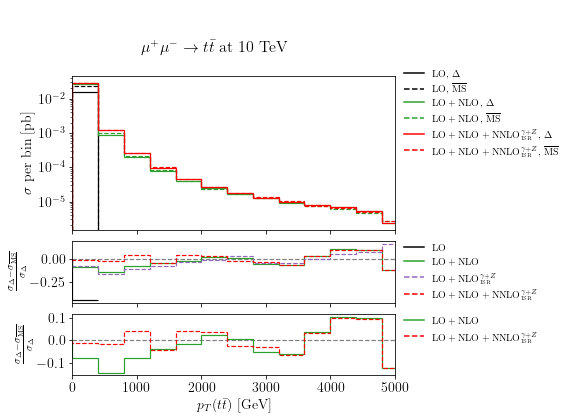

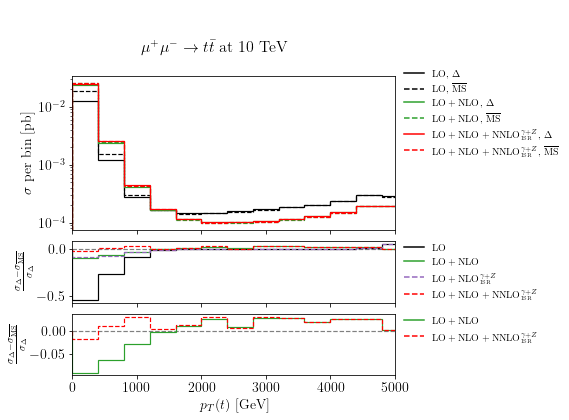

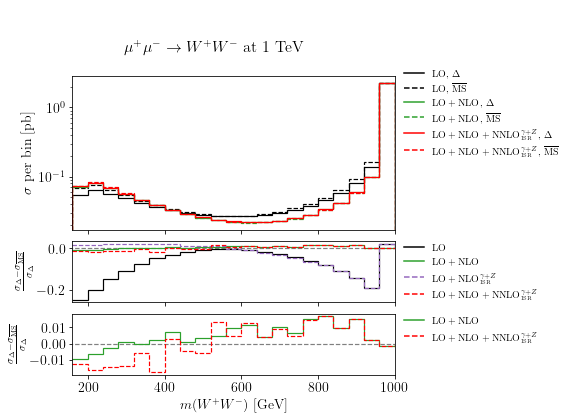

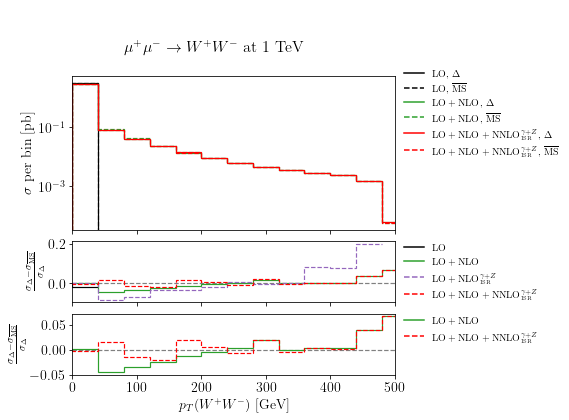

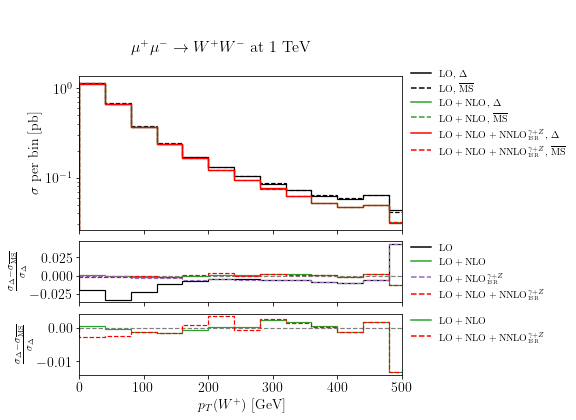

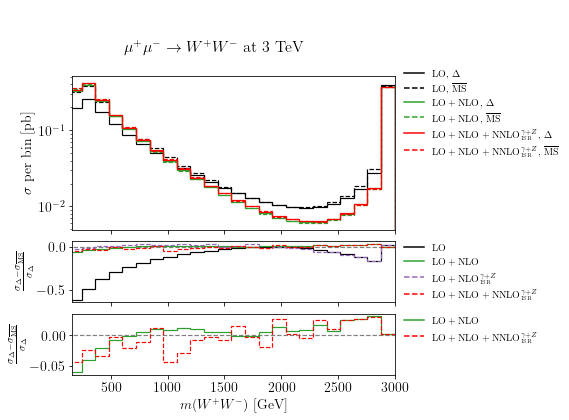

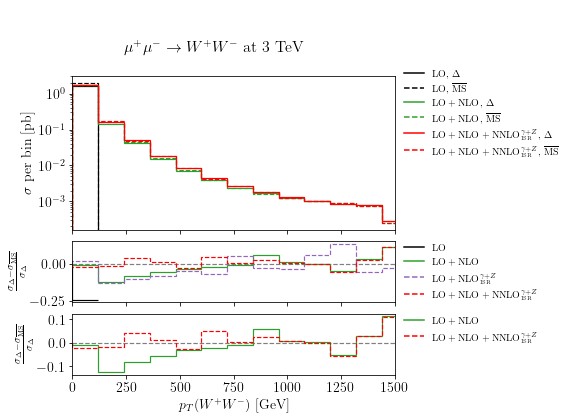

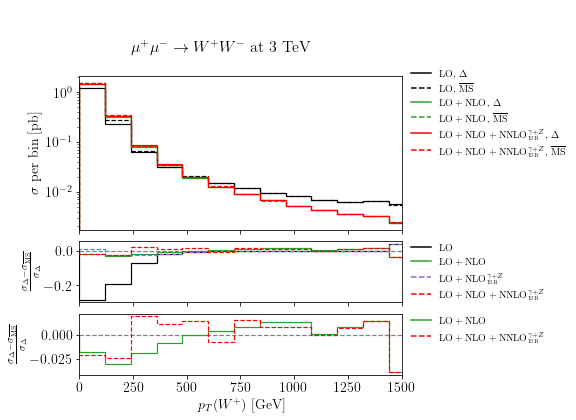

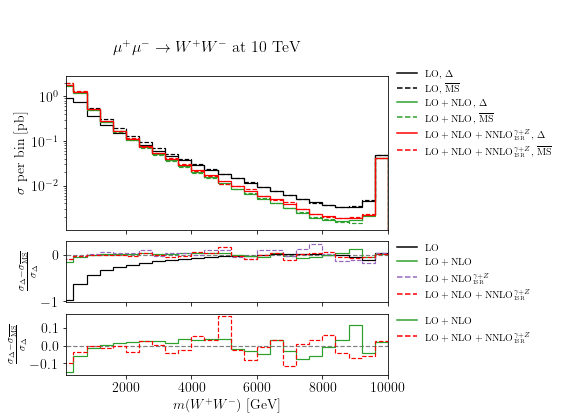

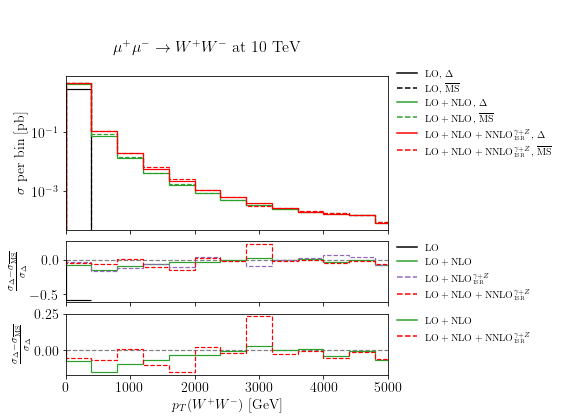

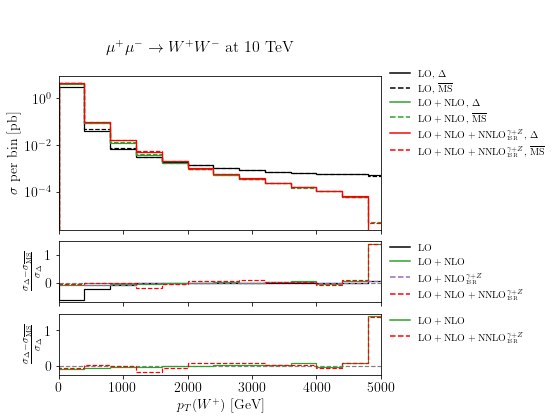

In [68]:
## msbar vs delta

energies = [1,3,10]
observables = ['mtt', 'pttt', 'pttop', 'top rap', 'tt rap']
observables = ['mtt', 'pttt', 'pttop']

#observables = ['top rap', 'tt rap']

processes = ['tt', 'ww']
#processes = ['ww',]
#energies = [3]


xlabels = {'tt': {'mtt': 'm(t\\bar t)',
                  'pttt': 'p_T(t\\bar t)',
                  'pttop': 'p_T(t)',
                  'thetatt': '\\theta(t\\bar t)',
                  'top rap': 'y(t)',
                  'tt rap': 'y(t\\bar t)'},
           'ww': {'mtt': 'm(W^+W^-)',
                  'pttt': 'p_T(W^+W^-)',
                  'pttop': 'p_T(W^+)',
                  'thetatt': '\\theta(W^+W^-)',
                  'top rap': 'y(W^+)',
                  'tt rap': 'y(W^+W^-)'}}
proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}


nrebin = 2

for p in processes:
    for en in energies:
        fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_03permil' % en, 'MADatNLO.HwU')
        fname_nnlo = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt' % en, 'MADatNLO.HwU')

        fname_mg_msb = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_03permil' % en, 'MADatNLO.HwU')
        fname_nnlo_msb = os.path.join(p, 'run_nnlo%d_fixqp_msb_mufmtt' % en, 'MADatNLO.HwU')

        rate_mg_lo = get_histo_from_file(fname_mg, 'total rate', 'LO', nrebin).totrate
        rate_mg_tot = get_histo_from_file(fname_mg, 'total rate', 'TOT', nrebin).totrate

        rate_mg_msb_lo = get_histo_from_file(fname_mg_msb, 'total rate', 'LO', nrebin).totrate
        rate_mg_msb_tot = get_histo_from_file(fname_mg_msb, 'total rate', 'TOT', nrebin).totrate

        for o in observables:
            #DELTA
            # mg histograms
            fixrate = (o == 'mtt')

            h_lo_mg = get_histo_from_file(fname_mg, o, 'LO', nrebin, fixrate, rate_mg_lo)
            h_loaa_mg = get_histo_from_file(fname_mg, o, 'LOAA', nrebin)
            h_nlo_mg = get_histo_from_file(fname_mg, o, 'NLO', nrebin)
            h_nlor_mg = get_histo_from_file(fname_mg, o, 'NLOR', nrebin)
            h_tot_mg = get_histo_from_file(fname_mg, o, 'TOT', nrebin, fixrate, rate_mg_tot)
            # nnlo histograms
            h_lo_nnlo = get_histo_from_file(fname_nnlo, o, 'LO', nrebin)
            h_nlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NLO', nrebin)
            h_nnlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NNLO', nrebin)

            #MSBAR
            # mg histograms
            h_lo_mg_msb = get_histo_from_file(fname_mg_msb, o, 'LO', nrebin, fixrate, rate_mg_msb_lo)
            h_loaa_mg_msb = get_histo_from_file(fname_mg_msb, o, 'LOAA', nrebin)
            h_nlo_mg_msb = get_histo_from_file(fname_mg_msb, o, 'NLO', nrebin)
            h_nlor_mg_msb = get_histo_from_file(fname_mg_msb, o, 'NLOR', nrebin)
            h_tot_mg_msb = get_histo_from_file(fname_mg_msb, o, 'TOT', nrebin, fixrate, rate_mg_msb_tot)
            # nnlo histograms
            h_lo_nnlo_msb = get_histo_from_file(fname_nnlo_msb, o, 'LO', nrebin)
            h_nlo_nnlo_msb = get_histo_from_file(fname_nnlo_msb, o, 'NLO', nrebin)
            h_nnlo_nnlo_msb = get_histo_from_file(fname_nnlo_msb, o, 'NNLO', nrebin)


            # now the figure
            fig, axes = plt.subplots(nrows = 3, ncols= 1, sharex = True,
                                     gridspec_kw={'height_ratios': [2.5, 1,1]})
            fig.set_size_inches(7*0.75,7*0.75)
            fig.suptitle("\n\n" + "    " + proc_string[p] + ' at %d TeV' % en, fontsize=16, y=1.1 )

            for ax in axes:
                pos = ax.get_position()
                ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
                ax.yaxis.set_minor_locator(AutoMinorLocator())

            #main frame, LO effect show absolute xsec
            for ax in axes[1:]:
                ax.set_ylabel("$\\frac{\\sigma_{\\Delta}-\\sigma_{\\overline{\\rm MS}}}{\sigma_{\\Delta}}$")


            if o == 'mtt':
                obsrange = (0.,en*1000.)
            elif o in ['pttt', 'pttop']:
                obsrange = (0.,en*1000.)
            elif o in ['thetatt']:
                obsrange = (0.,math.pi)
            elif o in ['top rap', 'tt rap']:
                obsrange = (-12,12)

            if o == 'mtt' and p == 'tt':
                ax.set_xlim(340,en*1000)
            if o == 'mtt' and p == 'ww':
                ax.set_xlim(160,en*1000)
            if o in ['pttt', 'pttop']:
                ax.set_xlim(0,en*1000/2)
            if o in ['thetatt']:
                ax.set_xlim(0,math.pi)
            if o in ['top rap', 'tt rap']:
                ax.set_xlim(-5,5)

            # absolute xsect
            ax = axes[0]
            ax.set_ylabel("$\sigma$ per bin [pb]")
            ax.set_yscale('log')
            hplot = h_lo_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO},\\,\\Delta$',
                   linewidth=lw, color=allcolors[1], linestyle='solid', range=obsrange)
            hplot = h_lo_mg_msb
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO},\\,\\overline{\\textrm{MS}}$',
                   linewidth=lw, color=allcolors[1], linestyle='dashed', range=obsrange)

            hplot = h_tot_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO},\\,\\Delta$',
                   linewidth=lw, color=allcolors[2], linestyle='solid', range=obsrange)
            hplot = h_tot_mg_msb

            print('TOTAL',en,o,p, h_tot_mg.totrate, h_tot_mg_msb.totrate)
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO},\\,\\overline{\\textrm{MS}}$',
                   linewidth=lw, color=allcolors[2], linestyle='dashed', range=obsrange)

            hplot = h_tot_mg + h_nnlo_nnlo
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR},\\,\\Delta$',
                   linewidth=lw, color=allcolors[3], linestyle='solid', range=obsrange)
            hplot = h_tot_mg_msb + h_nnlo_nnlo_msb
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR},\\,\\overline{\\textrm{MS}}$',
                   linewidth=lw, color=allcolors[3], linestyle='dashed', range=obsrange)

            update_legend(ax,1)

            ax = axes[1]
            ax.set_yscale('linear')

            # total
            #label = '$\\textrm{TOT}=\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
            hplot = h_lo_mg
            ax.hist(x = hplot['x'], weights = [0]*hplot['nbins'], histtype= 'step', bins = hplot['nbins'],
                   linewidth=lw, color='gray', linestyle='dashed', range=obsrange)
            
            hplot = (h_lo_mg - h_lo_mg_msb) / h_lo_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}$',
                   linewidth=lw, color=allcolors[1], range=obsrange)
            
            hplot = (h_tot_mg - h_tot_mg_msb) / h_tot_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}$',
                   linewidth=lw, color=allcolors[2], linestyle='solid', range=obsrange)
            
            hplot = (h_lo_mg + h_nlo_nnlo - h_lo_mg_msb - h_nlo_nnlo_msb) / (h_lo_mg + h_nlo_nnlo)
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
                   linewidth=lw, color=allcolors[4], range=obsrange, linestyle = 'dashed')
            
            hplot = (h_tot_mg + h_nnlo_nnlo - h_tot_mg_msb - h_nnlo_nnlo_msb) / (h_tot_mg + h_nnlo_nnlo)
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
                   linewidth=lw, color=allcolors[3], range=obsrange, linestyle = 'dashed')
            update_legend(ax,1)

            ax = axes[2]
            ax.set_yscale('linear')

            hplot = h_lo_mg
            ax.hist(x = hplot['x'], weights = [0]*hplot['nbins'], histtype= 'step', bins = hplot['nbins'],
                   linewidth=lw, color='gray', linestyle='dashed', range=obsrange)

            hplot = (h_tot_mg - h_tot_mg_msb) / h_tot_mg
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}$',
                   linewidth=lw, color=allcolors[2], linestyle='solid', range=obsrange)

            hplot = (h_tot_mg + h_nnlo_nnlo - h_tot_mg_msb - h_nnlo_nnlo_msb) / (h_tot_mg + h_nnlo_nnlo)
            ax.hist(x = hplot['x'], weights = hplot['y'], histtype= 'step', bins = hplot['nbins'],
                   label = '$\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
                   linewidth=lw, color=allcolors[3], range=obsrange, linestyle = 'dashed')

            update_legend(ax,1)

            ax.set_xlabel('$%s$ [GeV]' % xlabels[p][o])

            plt.savefig('delvsmsb_%s_%s_%dtev.pdf' % (o,p,en), bbox_inches = 'tight')






Not found,  tt/run_Wfusion_1tev/MADatNLO.HwU top rap LO
Not found,  tt/run_Wfusion_1tev/MADatNLO.HwU tt rap LO
Not found,  tt/run_Wfusion_3tev/MADatNLO.HwU top rap LO
Not found,  tt/run_Wfusion_3tev/MADatNLO.HwU tt rap LO
Not found,  tt/run_Wfusion_10tev/MADatNLO.HwU top rap LO
Not found,  tt/run_Wfusion_10tev/MADatNLO.HwU tt rap LO
Not found,  ww/run_Wfusion_1tev/MADatNLO.HwU top rap LO
Not found,  ww/run_Wfusion_1tev/MADatNLO.HwU tt rap LO


<ipython-input-69-d836fb75231b>:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows = 3, ncols= 1, sharex = True,


Not found,  ww/run_Wfusion_3tev/MADatNLO.HwU top rap LO
Not found,  ww/run_Wfusion_3tev/MADatNLO.HwU tt rap LO


<ipython-input-69-d836fb75231b>:144: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(min([v for v in h_tota['y'] if v !=0])/20, max(h_tota['y'])*2)


Not found,  ww/run_Wfusion_10tev/MADatNLO.HwU top rap LO
Not found,  ww/run_Wfusion_10tev/MADatNLO.HwU tt rap LO


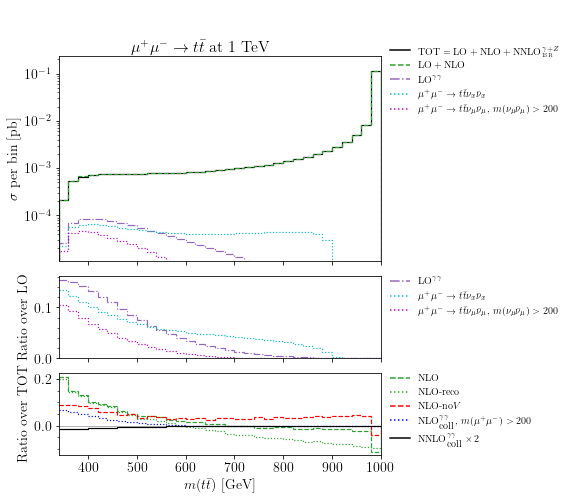

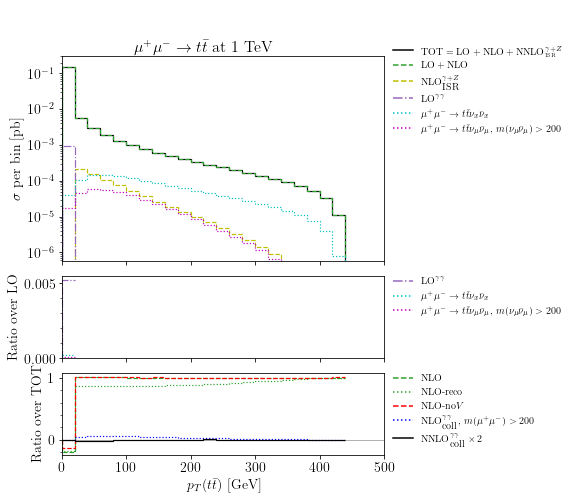

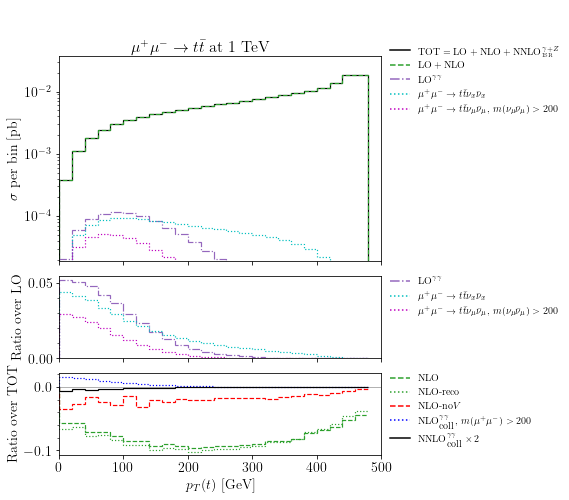

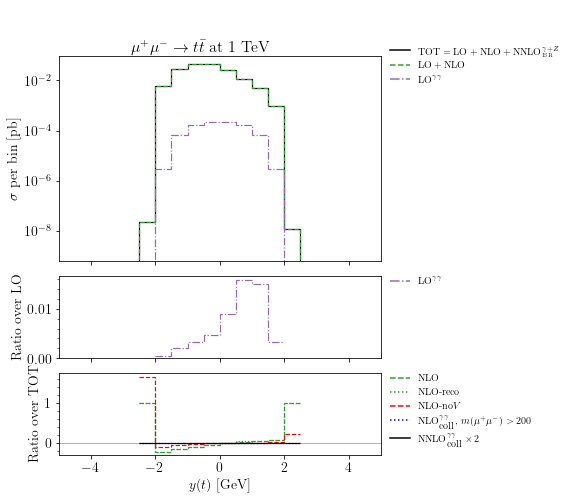

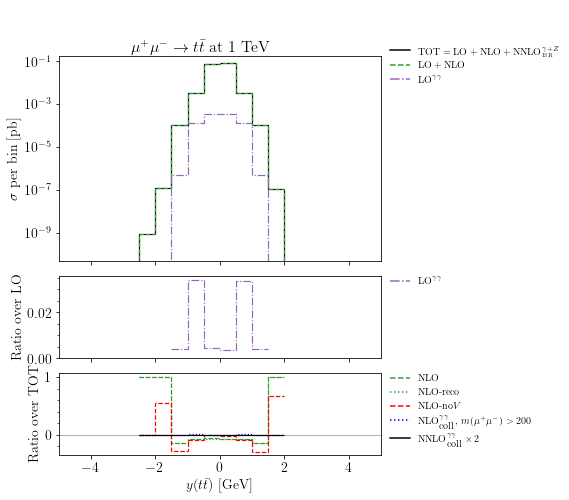

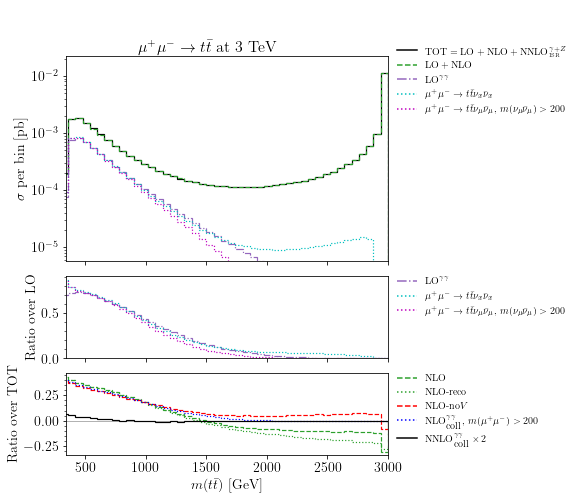

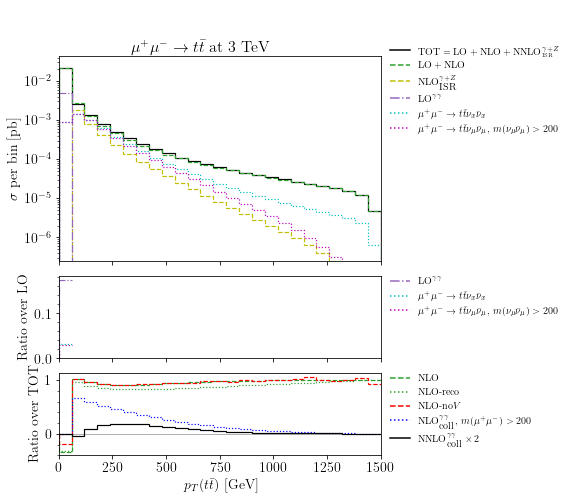

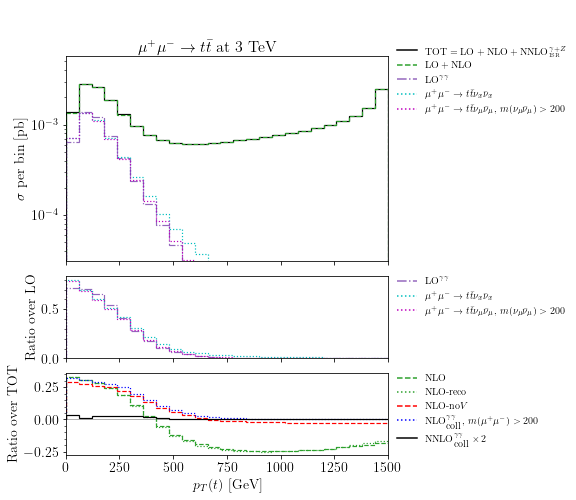

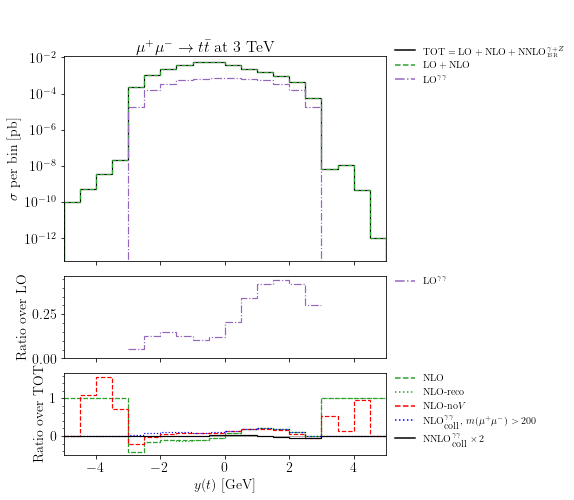

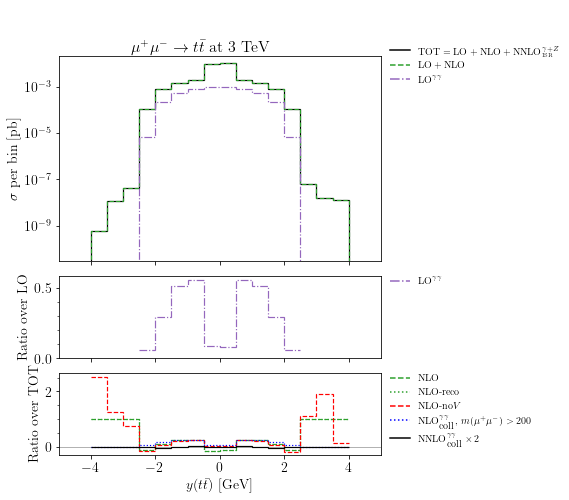

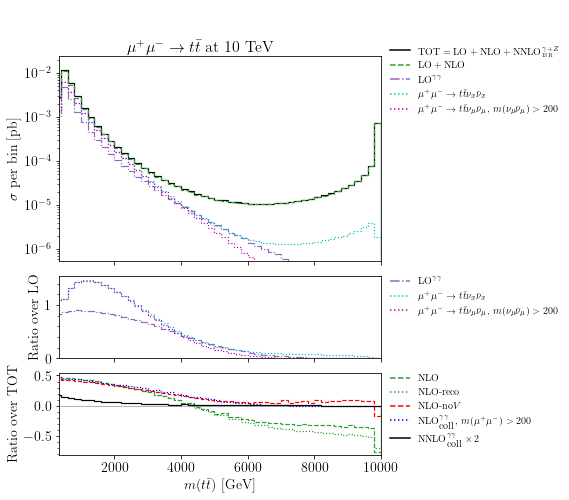

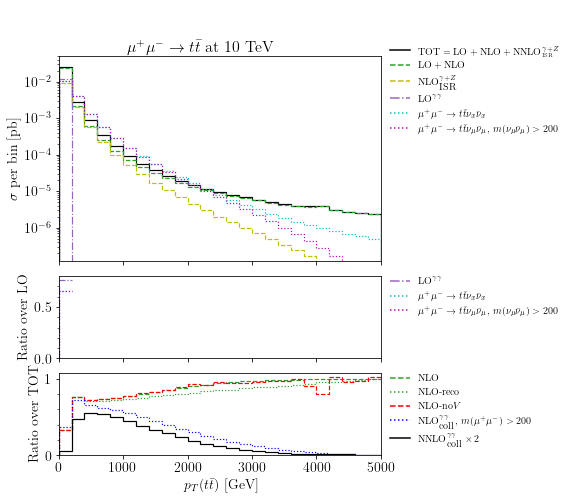

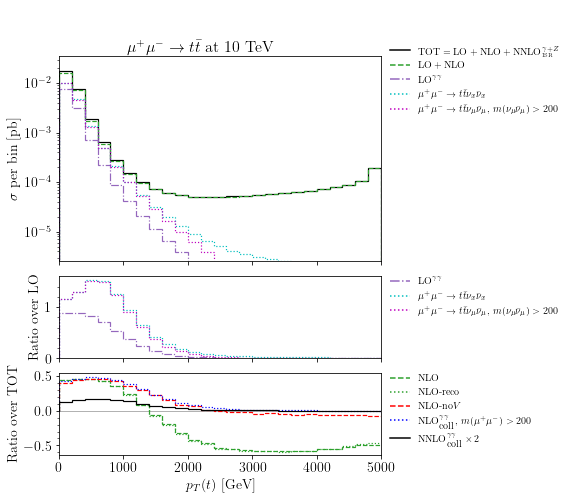

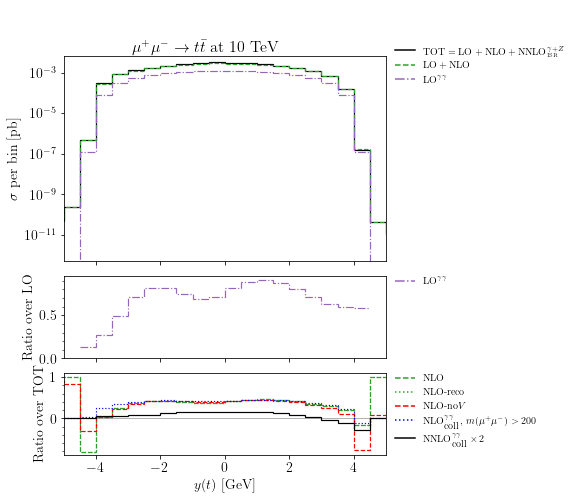

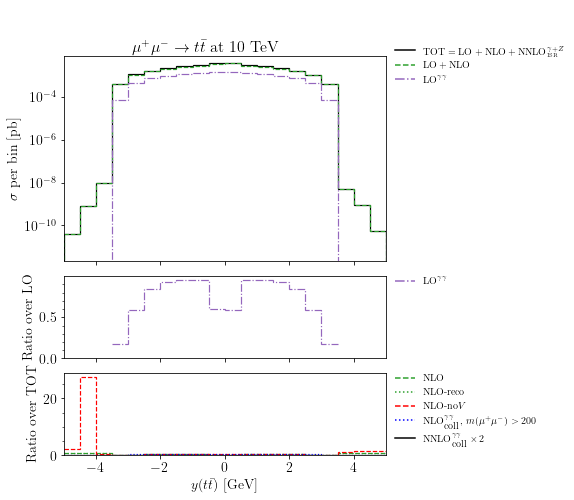

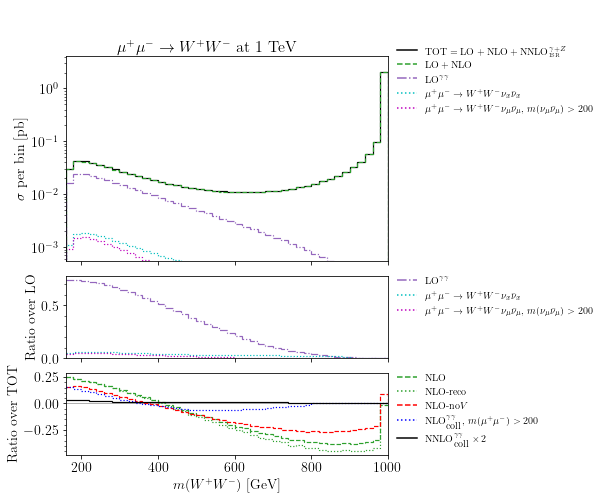

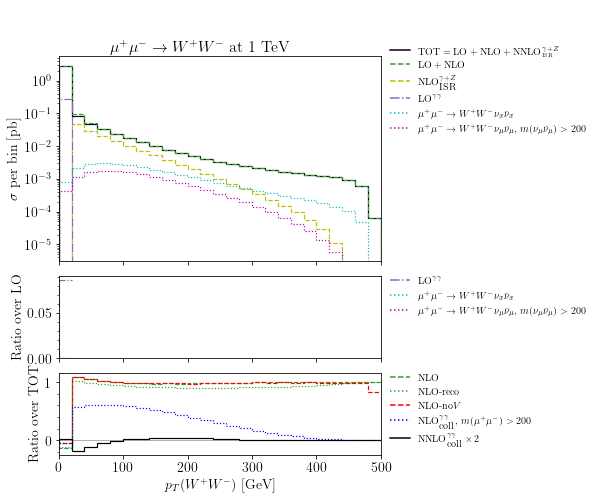

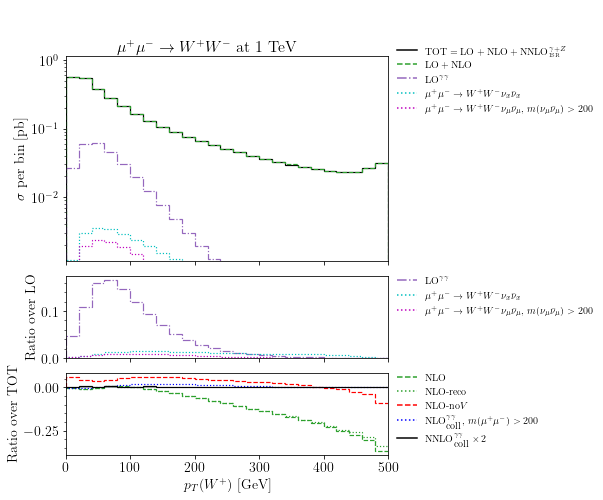

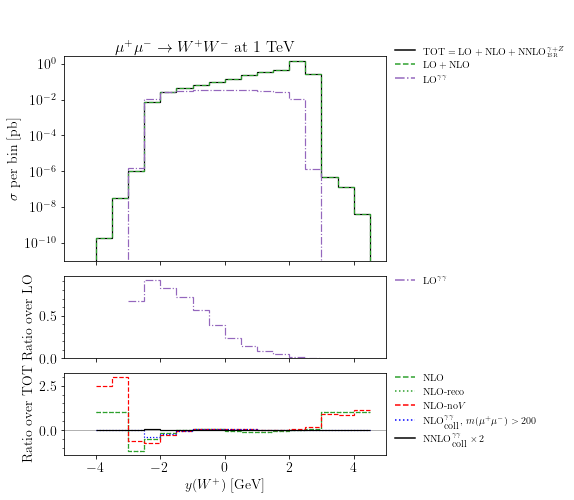

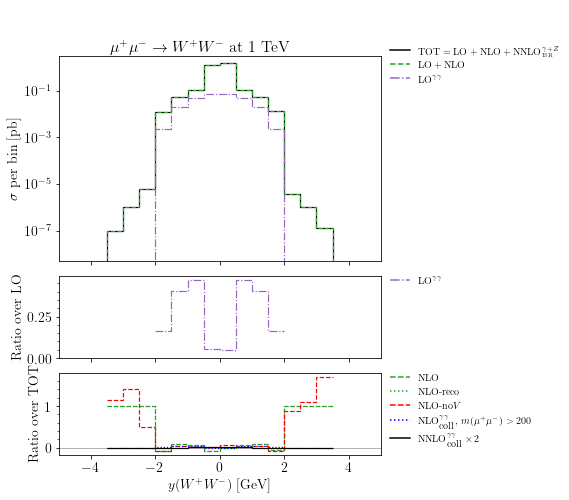

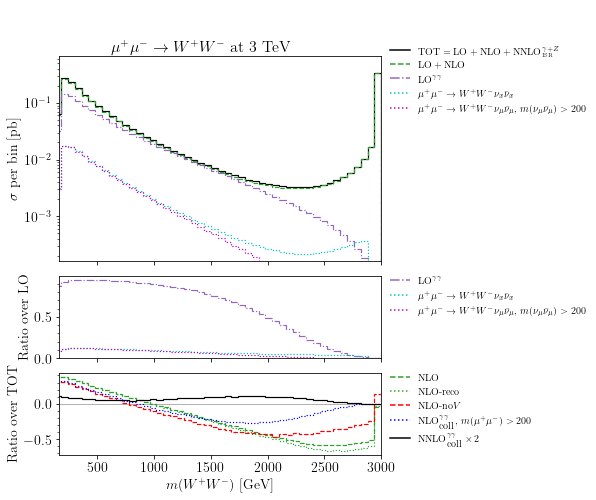

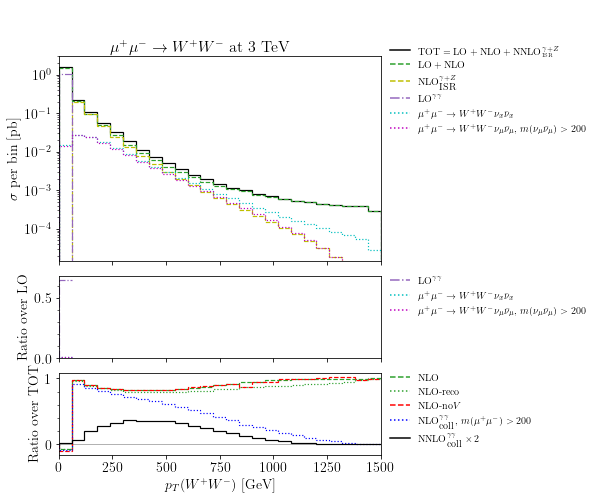

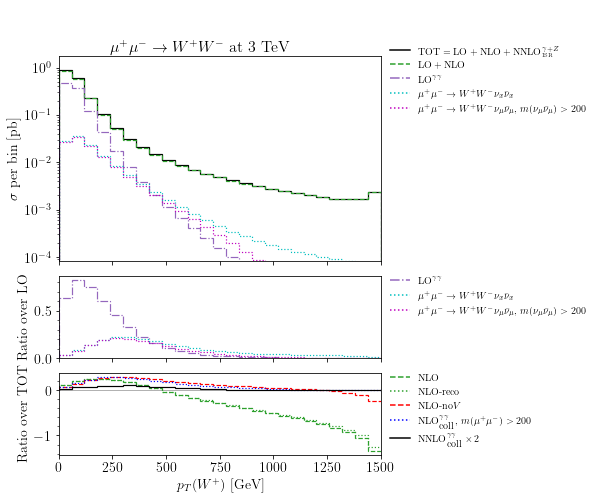

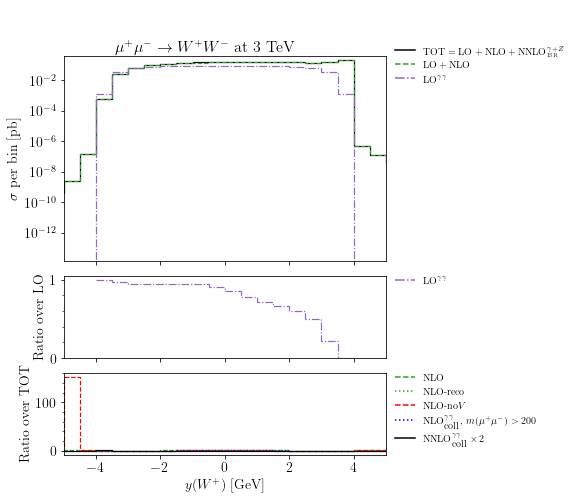

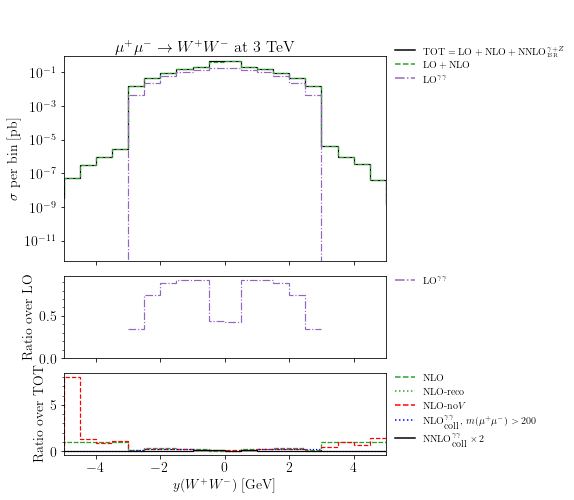

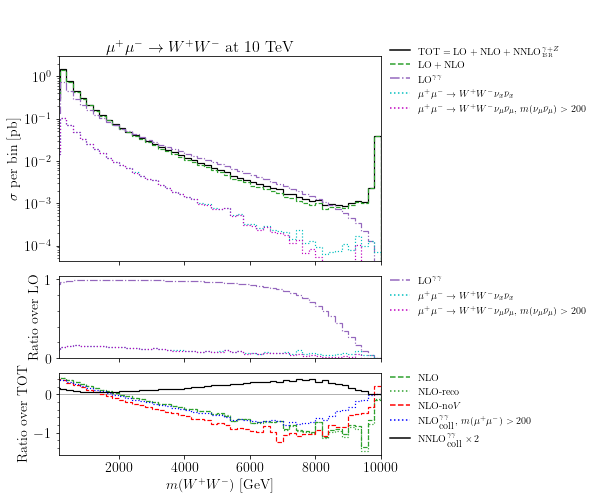

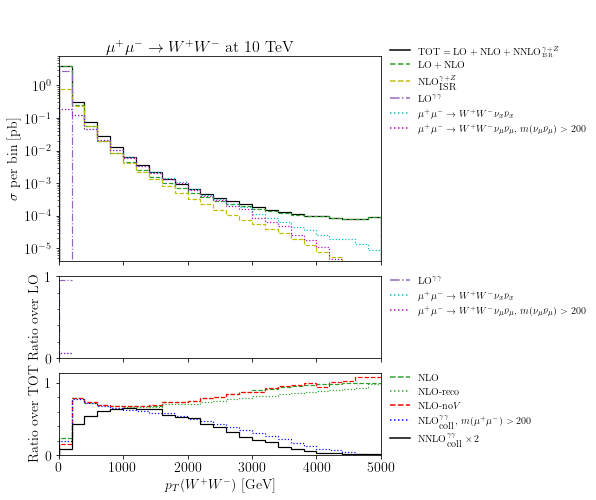

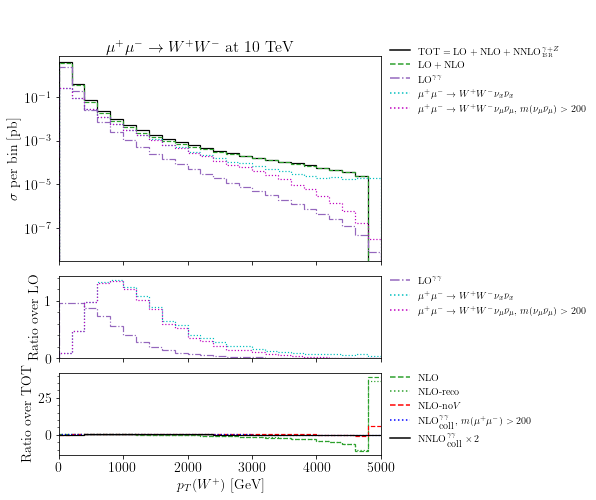

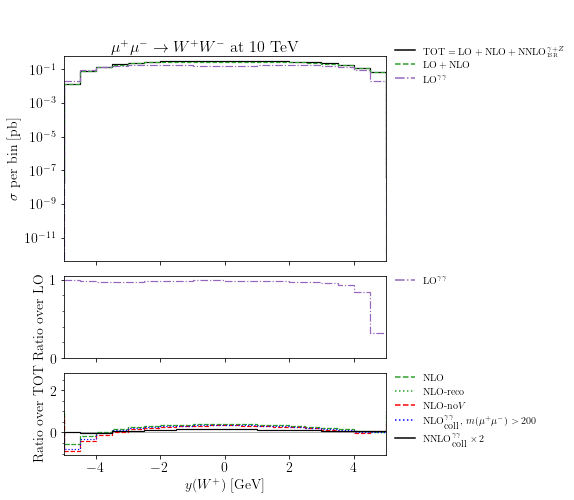

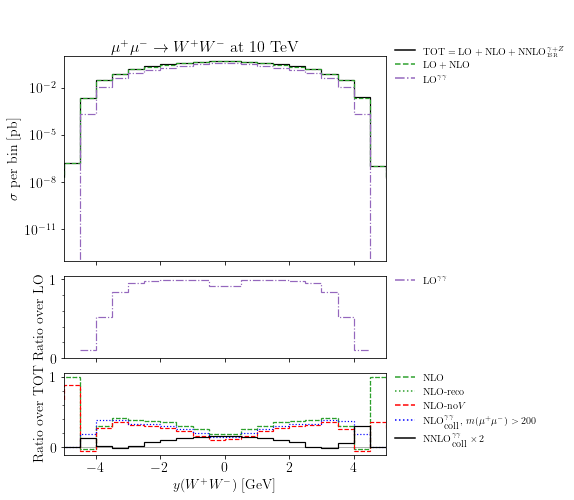

In [69]:
# observables and histograms


energies = [1,3,10]
observables = ['mtt', 'pttt', 'pttop', 'top rap', 'tt rap']
#observables = ['mtt', ]

#observables = ['top rap', 'tt rap']

processes = ['tt', 'ww']
#processes = ['ww',]
#energies = [3]


xlabels = {'tt': {'mtt': 'm(t\\bar t)',
                  'pttt': 'p_T(t\\bar t)',
                  'pttop': 'p_T(t)',
                  'thetatt': '\\theta(t\\bar t)',
                  'top rap': 'y(t)',
                  'tt rap': 'y(t\\bar t)'},
           'ww': {'mtt': 'm(W^+W^-)',
                  'pttt': 'p_T(W^+W^-)',
                  'pttop': 'p_T(W^+)',
                  'thetatt': '\\theta(W^+W^-)',
                  'top rap': 'y(W^+)',
                  'tt rap': 'y(W^+W^-)'}}
proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}
for p in processes:
    for en in energies:
        fname_mg = os.path.join(p, 'run_%dtev_NLO_mumtt_03permil' % en, 'MADatNLO.HwU')
        fname_mgnovi = os.path.join(p, 'run_%dtev_NLO_mumtt_03permil_novirt' % en, 'MADatNLO.HwU')
        fname_nnlo = os.path.join(p, 'run_nnlo%d_fixqp_mufmtt' % en, 'MADatNLO.HwU')
        fname_wbf = os.path.join(p, 'run_Wfusion_%dtev' % en, 'MADatNLO.HwU')
        #fname_nlo_ycut25 = os.path.join(p, 'run_nlo_%d_nomcut_ymin-2.5' % en, 'MADatNLO.HwU')
        #fname_nlo_ycut5 = os.path.join(p, 'run_nlo_%d_nomcut_ymin-5.0' % en, 'MADatNLO.HwU')
        #fname_nnlo_ycut25 = os.path.join(p, 'run_nnlo_%d_nomcut_nosameflav_ymin-2.5' % en, 'MADatNLO.HwU')
        #fname_nnlo_ycut5 = os.path.join(p, 'run_nnlo_%d_nomcut_nosameflav_ymin-5.0' % en, 'MADatNLO.HwU')
        for o in observables:
            try:
                # mg histograms
                h_lo_mg = get_histo_from_file(fname_mg, o, 'LO')
                h_loaa_mg = get_histo_from_file(fname_mg, o, 'LOAA')
                h_nlo_mgnovi = get_histo_from_file(fname_mgnovi, o, 'NLO')
                h_nlo_mg = get_histo_from_file(fname_mg, o, 'NLO')
                h_nlor_mg = get_histo_from_file(fname_mg, o, 'NLOR')
                h_tot_mg = get_histo_from_file(fname_mg, o, 'TOT')
                # nnlo histograms
                h_lo_nnlo = get_histo_from_file(fname_nnlo, o, 'LO')
                h_nlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NLO')
                h_nnlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NNLO')
                
                h_tota = h_nnlo_nnlo + h_tot_mg
            except (FileNotFoundError, HistoNotFound) as e:
                print(e)
                continue
            
            try:
                # wfusion histograms
                h_w_tot = get_histo_from_file(fname_wbf, o, 'LO')
                h_w_vmcut = get_histo_from_file(fname_wbf, o, 'LOVMC')
                foundww = True
            except (FileNotFoundError, HistoNotFound):
                foundww = False
                
            #try:
            #    # nlo_ycut_histograms histograms
            #    h_nlo_ycut25 = get_histo_from_file(fname_nlo_ycut25, o, 'NLO')
            #    h_nlo_ycut5 = get_histo_from_file(fname_nlo_ycut5, o, 'NLO')
            #    foundnloycut = True
            #except (FileNotFoundError, HistoNotFound):
            #    foundnloycut = False
            #    
            #try:
            #    # nnlo_ycut_histograms histograms
            #    h_nnlo_ycut25 = get_histo_from_file(fname_nnlo_ycut25, o, 'NNLO')
            #    h_nnlo_ycut5 = get_histo_from_file(fname_nnlo_ycut5, o, 'NNLO')
            #    foundnnloycut = True
            #except (FileNotFoundError, HistoNotFound):
            #    foundnnloycut = False
            
            # now the figure
            fig, axes = plt.subplots(nrows = 3, ncols= 1, sharex = True, 
                                     gridspec_kw={'height_ratios': [2.5,1,1]})
            fig.set_size_inches(7*0.75,7)
            fig.suptitle("\n\n" + "    " + proc_string[p] + ' at %d TeV' % en, fontsize=16, y=1.015 ) 
            
            for ax in axes:
                pos = ax.get_position()
                ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
                ax.yaxis.set_minor_locator(AutoMinorLocator())
            
            #main frame, show absolute xsec
            ax = axes[0]
            ax.set_ylabel("$\sigma$ per bin [pb]")
            ax.set_yscale('log')
            if o == 'mtt':
                obsrange = (0.,en*1000.)
            elif o in ['pttt', 'pttop']:
                obsrange = (0.,en*1000.)
            elif o in ['thetatt']:
                obsrange = (0.,math.pi)
            elif o in ['top rap', 'tt rap']:
                obsrange = (-12,12)
                
            if o == 'mtt' and p == 'tt':
                ax.set_xlim(340,en*1000)
            if o == 'mtt' and p == 'ww':
                ax.set_xlim(160,en*1000)
            if o in ['pttt', 'pttop']:
                ax.set_xlim(0,en*1000/2)
            if o in ['thetatt']:
                ax.set_xlim(0,math.pi)
            if o in ['top rap', 'tt rap']:
                ax.set_xlim(-5,5)
                
            # total
            ax.hist(x = h_tota['x'], weights = h_tota['y'], histtype= 'step', bins = h_tota['nbins'], 
                   label = '$\\textrm{TOT}=\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma+Z}_\\textrm{\\tiny ISR}$',
                   linewidth=lw, color=allcolors[1], range=obsrange)
            
            ax.hist(x = h_tot_mg['x'], weights = h_tot_mg['y'], histtype= 'step', bins = h_tot_mg['nbins'], 
                   label = '$\\textrm{LO}+\\textrm{NLO}$',
                   linewidth=lw, color=allcolors[2], linestyle='dashed', range=obsrange)
            
            if o == 'pttt':
                ax.hist(x = h_nlo_nnlo['x'], weights = h_nlo_nnlo['y'], histtype= 'step', bins = h_nlo_nnlo['nbins'], 
                   label = '$\\textrm{NLO}^{\\gamma+Z}_\\textrm{ISR}$',
                   linewidth=lw, color=allcolors[15], linestyle='dashed', range=obsrange)
            
            ax.hist(x = h_loaa_mg['x'], weights = h_loaa_mg['y'], histtype= 'step', bins = h_loaa_mg['nbins'], 
                   label = '$\\textrm{LO}^{\\gamma\\gamma}$',
                   linewidth=lw, color=allcolors[4], linestyle='-.', range=obsrange)
            
            if foundww:
                ax.hist(x = h_w_tot['x'], weights = h_w_tot['y'], histtype= 'step', bins = h_w_tot['nbins'], 
                   linewidth=lw, color=allcolors[13], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_x \\bar \\nu_x$", range=obsrange)
            
                ax.hist(x = h_w_vmcut['x'], weights = h_w_vmcut['y'], histtype= 'step', bins = h_w_vmcut['nbins'], 
                   linewidth=lw, color=allcolors[14], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_\\mu \\bar \\nu_\\mu$, $m(\\nu_\mu \\bar \\nu_\\mu)>200$", range=obsrange)            
            
            ax.set_ylim(min([v for v in h_tota['y'] if v !=0])/20, max(h_tota['y'])*2)
            update_legend(ax, ncol=1)

            # inset, lo gamma gamma / lo total
            ax=axes[1]
            ax.set_ylabel("$\\textrm{LO}^{\\gamma\\gamma}/\\textrm{LO}$")
            ax.set_ylabel("Ratio over LO")
            
            h_loratio = h_loaa_mg / h_lo_mg
            ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[4], linestyle='-.',
                   label="$\\textrm{LO}^{\\gamma\\gamma}$", range=obsrange)
            
            if foundww:
                h_loratio = h_w_tot / h_lo_mg
                ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[13], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_x \\bar \\nu_x$", range=obsrange)
            
                h_loratio = h_w_vmcut / h_lo_mg
                ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[14], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_\\mu \\bar \\nu_\\mu$, $m(\\nu_\mu \\bar \\nu_\\mu)>200$", range=obsrange)
            update_legend(ax, ncol=1)
            
            ax=axes[2]
            # second inset
            ax.set_ylabel("Ratio over TOT")
            ax.hist(x = h_lo_mg['x'], weights = [0]*h_lo_mg['nbins'], histtype= 'step', bins = h_lo_mg['nbins'], 
                   linewidth=lw/2, color='gray', linestyle='solid', range=obsrange)        
    
            h_kfac = h_nlo_mg / h_tota
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[2], linestyle='dashed', 
                    label = '$\\textrm{NLO}$', range=obsrange)
            
            h_kfac = h_nlor_mg / h_tota
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[2], linestyle='dotted', 
                    label = '$\\textrm{NLO-reco}$', range=obsrange)
            
            h_kfac = h_nlo_mgnovi / h_tota
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[3], linestyle='dashed', 
                    label = '$\\textrm{NLO-no}V$', range=obsrange)
            
            h_kfac = h_nlo_nnlo / h_tota
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[10], linestyle='dotted', 
                    label = '$\\textrm{NLO}^{\\gamma\\gamma}_\\textrm{coll}, \, m(\\mu^+\\mu^-)>200$', range=obsrange)
            
            if False:
                h_kfac = h_nlo_ycut25 / h_lo_mg
                ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[11], linestyle='dotted', 
                    label = '$\\textrm{NLO}^{\\gamma\\gamma}_\\textrm{coll}, \, \\mp\\eta(\\mu^\\pm) < 2.5$', range=obsrange)
                h_kfac = h_nlo_ycut5 / h_lo_mg
                ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[12], linestyle='dotted', 
                    label = '$\\textrm{NLO}^{\\gamma\\gamma}_\\textrm{coll}, \, \\mp\\eta(\\mu^\\pm) < 5$', range=obsrange)
            
            nnlo_rescale = 2
            h_kfac = h_nnlo_nnlo / h_tota * nnlo_rescale
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[1], linestyle='solid', 
                    label = '$\\textrm{NNLO}^{\\gamma\\gamma}_\\textrm{coll} \\times %d$' % nnlo_rescale, range=obsrange)
            
            #if False:
            #    h_kfac = h_nnlo_ycut25 / h_lo_mg * nnlo_rescale
            #    ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
            #       linewidth=lw, color=allcolors[11], 
            #        label = '$\\textrm{NNLO}^{\\gamma\\gamma}_\\textrm{coll}, \, \\mp\\eta(\\mu^\\pm) < 2.5 \\times %d $' % nnlo_rescale, range=obsrange)
            #    h_kfac = h_nnlo_ycut5 / h_lo_mg * nnlo_rescale
            #    ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
            #       linewidth=lw, color=allcolors[12], 
            #        label = '$\\textrm{NNLO}^{\\gamma\\gamma}_\\textrm{coll}, \, \\mp\\eta(\\mu^\\pm) < 5 \\times %d $' % nnlo_rescale, range=obsrange)
            
            update_legend(ax, ncol=1)
            
            ax.set_xlabel('$%s$ [GeV]' % xlabels[p][o])
            
            plt.savefig('%s_%s_%dtev.pdf' % (o,p,en), bbox_inches = 'tight')